In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import matplotlib.pyplot as plt
from sklearn.decomposition import  PCA
from sklearn.manifold import TSNE
import torch.optim as optim
import numpy as np
import random
import datasets
from transformers import AlbertForMaskedLM, AlbertConfig
from tqdm import tqdm

/Users/grace/opt/anaconda3/envs/BE205_downgrade/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("mps")

In [3]:
ds = datasets.load_dataset("damlab/uniprot")
ds["train"]["sequence"][0] # Inspect the sequence data

Found cached dataset parquet (/Users/grace/.cache/huggingface/datasets/damlab___parquet/damlab--uniprot-28c00e1433a53e45/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


'MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQVECPKAPVEWNNPPSEKGLIVGHFSGIKYKGEKAQASEVDVNKMCCWVSKFKDAMRRYQGIQTCKIPGKVLSDLDAKIKAYNLTVEGVEGFVRYSRVTKQHVAAFLKELRHSKQYENVNLIHYILTDKRVDIQHLEKDLVKDFKALVESAHRMRQGHMINVKYILYQLLKKHGHGPDGPDILTVKTGSKGVLYDDSFRKIYTDLGWKFTPL'

In [4]:
seqs = ds["train"]["sequence"]
random.shuffle(seqs)

In [5]:
aas = sorted(list(set("".join(seqs))))
stoi = {s:i+1 for i,s in enumerate(aas)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 0: '.'}


In [6]:
context_length = 20
def make_dataset(seqs):
    X, y = [], []
    for s in tqdm(seqs):
        context = [0] * context_length
        for aa in s + ".":
            X.append(context[:context_length] + [stoi[aa]])
            y.append(context[1:] + [stoi[aa], stoi['.']])
            context = context[1:] + [stoi[aa]]
    X, y = torch.tensor(X), torch.tensor(y)
    return X, y

In [7]:
N = 50000
Xtrain, ytrain = make_dataset(seqs[:int(0.9*N)])
Xtest, ytest = make_dataset(seqs[int(0.9*N):N])

100%|██████████| 5000/5000 [00:05<00:00, 952.41it/s] 


In [24]:
config = AlbertConfig(vocab_size=len(itos), embedding_size=16, hidden_size=512, intermediate_size=1024, num_attention_heads=16)
model = AlbertForMaskedLM(config)

In [25]:
model = model.double()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20
# model = model.to(device)

In [26]:
losses = []
for step in tqdm(range(100)):
    ix = torch.randint(0, Xtrain.shape[0], (32,))
    labels = ytrain[ix]
    outputs = model(Xtrain[ix], labels=labels)
    loss = outputs.loss
    losses.append(loss.detach().numpy())
    loss.backward()
    optimizer.step()
    if step % 10 == 0:
        print(f"{step=}, {loss=}")


  1%|          | 1/100 [00:02<03:21,  2.04s/it]

step=0, loss=tensor(3.2583, dtype=torch.float64, grad_fn=<NllLossBackward0>)


 11%|█         | 11/100 [00:18<02:24,  1.63s/it]

step=10, loss=tensor(3.1810, dtype=torch.float64, grad_fn=<NllLossBackward0>)


 21%|██        | 21/100 [00:34<02:07,  1.62s/it]

step=20, loss=tensor(3.1120, dtype=torch.float64, grad_fn=<NllLossBackward0>)


 31%|███       | 31/100 [00:50<01:52,  1.63s/it]

step=30, loss=tensor(3.0681, dtype=torch.float64, grad_fn=<NllLossBackward0>)


 41%|████      | 41/100 [01:06<01:35,  1.61s/it]

step=40, loss=tensor(3.0203, dtype=torch.float64, grad_fn=<NllLossBackward0>)


 51%|█████     | 51/100 [01:23<01:20,  1.65s/it]

step=50, loss=tensor(2.9780, dtype=torch.float64, grad_fn=<NllLossBackward0>)


 61%|██████    | 61/100 [01:39<01:02,  1.61s/it]

step=60, loss=tensor(3.0152, dtype=torch.float64, grad_fn=<NllLossBackward0>)


 71%|███████   | 71/100 [01:55<00:47,  1.63s/it]

step=70, loss=tensor(2.9942, dtype=torch.float64, grad_fn=<NllLossBackward0>)


 81%|████████  | 81/100 [02:11<00:30,  1.63s/it]

step=80, loss=tensor(3.0559, dtype=torch.float64, grad_fn=<NllLossBackward0>)


 91%|█████████ | 91/100 [02:27<00:14,  1.62s/it]

step=90, loss=tensor(2.9613, dtype=torch.float64, grad_fn=<NllLossBackward0>)


100%|██████████| 100/100 [02:42<00:00,  1.63s/it]


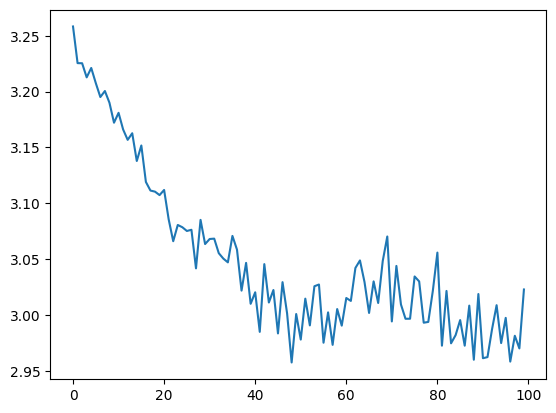

In [27]:
plt.plot(losses)

In [28]:
weight = next(model.named_parameters())[1].detach().numpy()
pca = PCA(n_components=2)
vis = pca.fit_transform(weight)

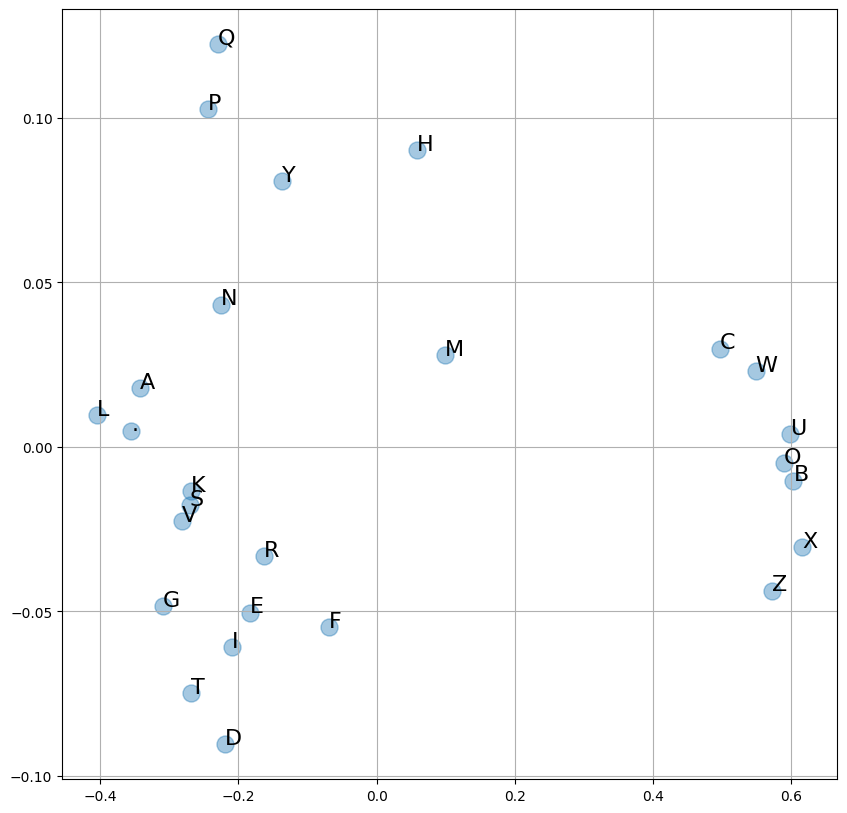

In [29]:
plt.figure(figsize=(10,10))
plt.scatter(vis[:, 0], vis[:, 1], s=150, alpha=0.4)
plt.grid(True)
for ix, char in itos.items():
    plt.annotate(char, vis[ix], fontsize=16)